In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd
from sklearn.feature_extraction import DictVectorizer
from pandas.core.frame import DataFrame

In [3]:
file = "/Users/gejiali/study/ECE/Spring2018/EC500/project/listings.csv"
df = pd.read_csv(file)
df = df[['id','name','summary','longitude','latitude','space','description','instant_bookable','neighborhood_overview',
         'neighbourhood_cleansed','host_id','host_name','host_since','host_response_time','street', 'zipcode',
         'review_scores_rating','property_type','room_type','accommodates','bathrooms','bedrooms','beds',
         'reviews_per_month','amenities','cancellation_policy','number_of_reviews','price']]

df.fillna(0, inplace=True)
price = df['price']
prices = []
for i in range(len(price)):
    p = float(price[i][1:].replace(',',''))
    prices.append(p)
df['price'] = prices

In [4]:
neighbour_df = df.groupby('neighbourhood_cleansed').id.count()
neighbour_df = neighbour_df.reset_index()
neighbour_df.rename(columns={'neighbourhood_cleansed':'neighbourhood', 'id':'total_number_of_houses'}, inplace = True)
neighbour_df = neighbour_df.sort_values('total_number_of_houses',ascending=[0])

neighbour_df2 = df.groupby('neighbourhood_cleansed').price.mean()
neighbour_df2 = neighbour_df2.reset_index()
neighbour_df2.rename(columns={'neighbourhood_cleansed':'neighbourhood', 'price':'average_price'}, inplace = True)
neighbour_df2 = neighbour_df2.sort_values('average_price',ascending=[0])

num_and_price = pd.merge(neighbour_df, neighbour_df2)
print(num_and_price)

              neighbourhood  total_number_of_houses  average_price
0             Jamaica Plain                     416     141.670673
1                  Back Bay                     410     239.880488
2                Dorchester                     400      97.915000
3                    Fenway                     357     210.862745
4                 South End                     354     214.519774
5                   Allston                     297      99.632997
6                  Downtown                     295     252.318644
7                  Brighton                     288     107.413194
8               Beacon Hill                     266     201.857143
9              South Boston                     264     197.825758
10              East Boston                     259     116.822394
11                  Roxbury                     241     127.684647
12                North End                     201     184.218905
13              Charlestown                     150     229.49

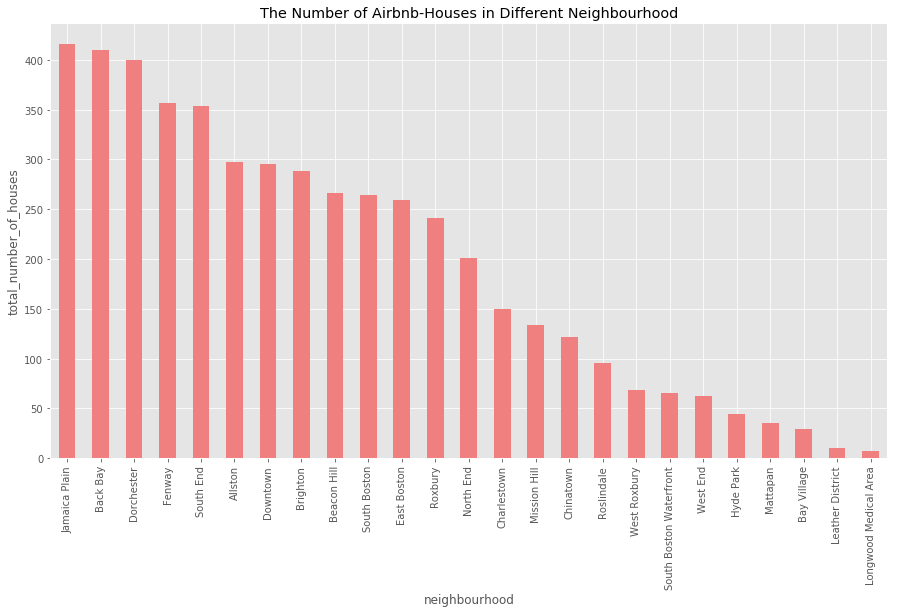

In [5]:
matplotlib.style.use('ggplot')

objects = num_and_price['neighbourhood']
y_pos = num_and_price['total_number_of_houses']

num_and_price.plot(kind='bar', 
           x = 'neighbourhood',
           y = 'total_number_of_houses',
           color = 'lightcoral', 
           figsize =(15,8), 
           title = 'The Number of Airbnb-Houses in Different Neighbourhood', 
           legend = False)

plt.ylabel('total_number_of_houses')
plt.show()

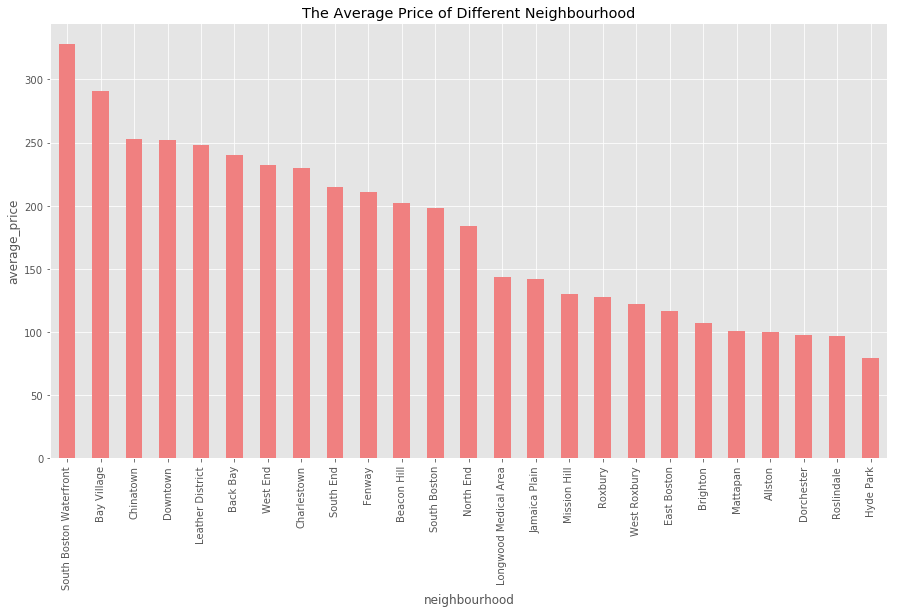

In [6]:
matplotlib.style.use('ggplot')

objects = neighbour_df2['neighbourhood']
y_pos = neighbour_df2['average_price']

neighbour_df2.plot(kind='bar', 
           x = 'neighbourhood',
           y = 'average_price',
           color = 'lightcoral', 
           figsize =(15,8), 
           title = 'The Average Price of Different Neighbourhood', 
           legend = False)

plt.ylabel('average_price')
plt.show()

In [7]:
neighbour_name = np.array(neighbour_df['neighbourhood']).tolist()
res = []
for item in neighbour_name:
    temp = []
    little_df = df[df['neighbourhood_cleansed'].isin([item])] 
    des = little_df['description']
    for items in des:
        temp.append(np.array(str(items)).tolist())
    res.append(temp)
print(len(res))

25


In [15]:
res_word = []
for i in range(len(res)):
    vectorizer = TfidfVectorizer(stop_words='english', min_df=0.1,max_df=0.8)
    dtm = vectorizer.fit_transform(res[i])
    terms = vectorizer.get_feature_names()
#     print(dtm.toarray())
#     print(terms)
    dtm_dense = dtm.todense()
    centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)
    np.sum(centered_dtm,axis=0)[:,:10]
    u, s, vt = np.linalg.svd(centered_dtm)
    
#     k_term = [] 
#     for k in range(6):    
    top = np.argsort(vt)
    topterms = [terms[top[0,f]] for f in range(6)]
#     k_term.append(topterms[0])
    res_word.append(topterms)
print(res_word)

[['park', 'equipped', 'amenities', 'fully', 'fenway', 'appliances'], ['place', 'center', 'prudential', 'walk', 'close', 'line'], ['place', 'station', 'close', 'line', 'train', 'min'], ['place', 'street', 'line', 'walking', 'museum', 'prudential'], ['apartment', 'bedroom', 'room', 'kitchen', 'living', 'bed'], ['mins', 'university', 'harvard', 'bus', 'area', 'station'], ['need', 'stay', 'crossing', 'shopping', 'll', 'downtown'], ['line', 'boston', 'close', 'place', 'green', 'minutes'], ['place', 'charles', 'walk', 'street', 'travelers', 'solo'], ['southie', 'need', 'stay', 'seaport', 'broadway', 'speed'], ['train', '10', 'beach', 'orient', 'heights', 'walking'], ['bedroom', 'unit', 'apartment', 'queen', 'living', 'historic'], ['end', 'church', 'old', 'street', 'italian', 'station'], ['monument', 'bunker', 'hill', 'yard', 'charlestown', 'navy'], ['room', 'apartment', 'bedroom', 'place', 'line', 'bathroom'], ['walk', 'minutes', 'including', 'new', 'station', 'downtown'], ['place', 'roslind

In [16]:
c = {"neighbourhood" : neighbour_name,
     "top 6 key words in description": res_word}
#print(c)
des_data = DataFrame(c)
print(des_data)

              neighbourhood                     top 6 key words in description
0             Jamaica Plain  [park, equipped, amenities, fully, fenway, app...
1                  Back Bay     [place, center, prudential, walk, close, line]
2                Dorchester          [place, station, close, line, train, min]
3                    Fenway  [place, street, line, walking, museum, prudent...
4                 South End   [apartment, bedroom, room, kitchen, living, bed]
5                   Allston    [mins, university, harvard, bus, area, station]
6                  Downtown     [need, stay, crossing, shopping, ll, downtown]
7                  Brighton       [line, boston, close, place, green, minutes]
8               Beacon Hill    [place, charles, walk, street, travelers, solo]
9              South Boston    [southie, need, stay, seaport, broadway, speed]
10              East Boston       [train, 10, beach, orient, heights, walking]
11                  Roxbury  [bedroom, unit, apartme

In [19]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc7 in position 0: invalid continuation byte

In [20]:
uniqueNeighborhoods = df.neighbourhood_cleansed.unique().tolist()

#function to clean the data and compile a list of most common words
def cleanData(neighbrhood_name,descrip):
    p = re.sub('[^a-zA-Z]+',' ', descrip)
    cmn_words=['The','I','Boston','room']
    descrip_data=nltk.word_tokenize(p)
    filtered_data=[word.lower() for word in descrip_data if word not in cmn_words if word not in stopwords.words('english')] 
    wnl = nltk.WordNetLemmatizer() 
    counts=Counter([wnl.lemmatize(data) for data in filtered_data])
    commn_words=[]
    for w in counts.most_common(5):
        commn_words.append(w[0])
    return ' '.join(commn_words)

summ={}
for n in uniqueNeighborhoods:
    text=''
    for index,row in df.iterrows():
        if row['neighbourhood_cleansed']==n:
            if ((row['description']!=0) & (row['space']!=0) & (row['neighborhood_overview']!=0)):
                text =text+row['description']+row['space']+row['neighborhood_overview']
    summ[n]=text

final_DF_neighbrhood=pd.DataFrame(columns=['neighborhood','top 5 words in description'])
for a in summ.items():
    top5words=cleanData(a[0],a[1])
    final_DF_neighbrhood=final_DF_neighbrhood.append(pd.Series([a[0],top5words],index=['neighborhood','top 5 words in description']),ignore_index=True)

#final_DF_neighbrhood.to_csv('top_words_description.csv')
print(final_DF_neighbrhood)

               neighborhood                     top 5 words in description
0                Roslindale      roslindale house minute neighborhood home
1             Jamaica Plain    jamaica walk minute restaurant neighborhood
2              Mission Hill           mi park restaurant amenity apartment
3     Longwood Medical Area           medical available bed living parking
4               Bay Village                   bay village bedroom walk bed
5          Leather District                 bed bedroom district south end
6                 Chinatown           mi district apartment center theater
7                 North End            north end apartment bedroom kitchen
8                   Roxbury           bedroom bed neighborhood floor house
9                 South End            end south restaurant unit apartment
10                 Back Bay              apartment bay back street bedroom
11              East Boston  airport bedroom minute apartment neighborhood
12              Charlesto